In [1]:
from IPython.display import Latex, display
from sympy import *
from numpy import zeros
from itertools import product

init_printing() 


def inverse_metric_cal(xmetric):
    """
    Taking the inverse of a metric tensor
        
    Args:
        xmetric: the metric tensor, g_ij
    
    Returns:
        inverse_metric: the inverse of the metric tensor,g^ij
    """
    inverse_metric = MutableSparseNDimArray(zeros((ndim,)*2))
    for i in range(ndim):
        inverse_metric[i, i] = 1 / xmetric[i, i]
    return nsimplify(inverse_metric)


def derivative_of_metric(xmetric, i, j, k):
    """
    Taking the partial derivative of a given metric: \partial_i(g_jk)
    where g_jk is the metric and the \partial_i is the partial derivative with respect 
    to i'th component 
    
    Args:
        xmetric: the metric tensor, g_jk
        i,j,k: indices that runs from 0-ndim
        
    Returns: 
        The partial derivative of g_jk with respect to the [i]'th component
    """
    expr = xmetric[j, k]
    return nsimplify(diff(expr, coord_sys[i]))


def derivative_of_chris(xchris_symb, i, j, k, l):
    """
    Taking the derivative of a given christoffel symbol; \partial_i (\Gamma^j_kl)
    where \Gamma^j_kl is the christoffel symbol and the \partial_i is the partial derivative 
    with respect to i'th component 
    
    Args:
        xchris_symb: the Christoffel Symbol C^j_kl
        i,j,k,l: indices that runs from 0-ndim
        
    Returns: 
        The partial derivative of C^j_kl with respect to the [i]'th component
    """
    expr = xchris_symb[j, k, l]
    return nsimplify(diff(expr, coord_sys[i]))


def christoffel_symbol_cal(xmetric):
    """
    Calculating the Christoffel Symbols
    
    Args:
        xmetric: the metric tensor, g_mk
        
    Returns: 
        chris_sym: Christoffel Symbols, C^m_ij
    """
    # creating an empty tensor to fill
    chris_sym = MutableSparseNDimArray(zeros((ndim,)*3))
    xg_inverse = inverse_metric_cal(xmetric)  
    for m, i, j in product(range(ndim), repeat = 3):
        einstein_sum = 0
        for k in range (ndim):
            I1 = derivative_of_metric(xmetric, j, k, i)
            I2 = derivative_of_metric(xmetric, i, k, j)
            I3 = derivative_of_metric(xmetric, k, i, j)
            S = I1 + I2 - I3
            einstein_sum += 1/2 * xg_inverse[m, k] * S     
        chris_sym[m, i, j] = einstein_sum
    return nsimplify(chris_sym)


def riemann_tensor_cal(xmetric, xchris_symbol, type = (1, 3)):
    """
    Calculating the Riemann Curvature Tensor with a given rank (M, N) with M-times contravariant and N-times covariant
    
    Args:
        xmetric: the metric tensor, g_pl
        xchris_symbol: Christoffel Symbols, C^m_ij
        rank: (M,N), M-times contravariant and N-times covariant
    
    Returns:
        riemann_curv_tensor [tuple]: the Riemann Curvature Tensor as R^l_ijk or R_ijkl, accompanied with the rank
    """
    # creating an empty tensor to fill
    riemann_tensor_13 = MutableSparseNDimArray(zeros((ndim,)*4))
    riemann_tensor_04 = MutableSparseNDimArray(zeros((ndim,)*4))
    for l, i, j, k in product(range(ndim), repeat = 4):
        Q1 = derivative_of_chris(xchris_symbol, j, l, i, k)
        Q2 = derivative_of_chris(xchris_symbol, i, l, j, k)
        einstein_sum = 0
        for p in range(ndim):
            I1 = xchris_symbol[p, i, k] * xchris_symbol[l, j, p]
            I2 = xchris_symbol[p, j, k] * xchris_symbol[l, i, p]
            einstein_sum += (I1 - I2)
        riemann_tensor_13[l, i, j, k] = Q1 - Q2 + einstein_sum
    riemann_curv_tensor_13 = (riemann_tensor_13, (1,3))
    if type == (1, 3):
        return nsimplify(riemann_curv_tensor_13)
    elif type == (0, 4):
        for i, j, k, l in product(range(ndim), repeat = 4):
            einstein_sum = 0
            for p in range(ndim):
                einstein_sum += riemann_curv_tensor_13[0][p, i, j, k] * xmetric[p, l]
            riemann_tensor_04[l, i, j, k] = einstein_sum
        riemann_curv_tensor_04 = (riemann_tensor_04, (0,4))
        return nsimplify(riemann_curv_tensor_04)
    else:
        raise ValueError("The rank of the metric tensor should be either (1,3) or (0,4)")


def ricci_tensor_cal(xmetric, xriemann_curv_tensor):
    """
    Calculating the Ricci Curvature Tensor
    
    Args:
        xmetric: the metric tensor, g_lj
        xriemann_curv_tensor [tuble]: the Riemann Curvature Tensor as R^l_ijk or R_ijkl accompanied with the rank
    
    Returns:
        ricci_tensor: the Ricci Tensor, R_ik
    """
    # creating an empty tensor to fill
    ricci_tensor = MutableSparseNDimArray(zeros((ndim,)*2))
    xg_inverse = inverse_metric_cal(xmetric)
    xriemann_tensor = xriemann_curv_tensor[0]
    type = xriemann_curv_tensor[1]
    if type == (1, 3):
        for i, k in product(range(ndim), repeat = 2):
            einstein_sum = 0
            for j in range(ndim):
                einstein_sum += xriemann_tensor[j, i, j, k]
            ricci_tensor[i, k] = einstein_sum
        return nsimplify(ricci_tensor)
    else:
        for j, l in product(range(ndim), repeat = 2):
            einstein_sum = 0
            for i, k in product(range(ndim), repeat = 2):
                einstein_sum += xriemann_tensor[i, j, k, l] * xg_inverse[i, k]
            ricci_tensor[j, l] = einstein_sum
        return nsimplify(ricci_tensor)

    
def ricci_scalar_cal(xmetric, xricci_tensor):
    """
    Calculating the Ricci Scalar
    
    Args:
        xmetric: the metric tensor, g_ij
        xricci_tensor: the Ricci Tensor, R_ik
        
    Returns: 
        ricci_scalar: the Ricci Scalar, R
    """
    xg_inverse = inverse_metric_cal(xmetric)
    ricci_scalar = 0
    for i, k in product(range(ndim), repeat = 2):
        ricci_scalar += xg_inverse[i, k] * xricci_tensor[i, k]
    return nsimplify(ricci_scalar)


def traceless_ricci_tensor_cal(xmetric, xricci_tensor, xricci_scalar):
    """
    Calculating the Traceless Ricci Tensor

    Args:
        xmetric: the metric tensor, g_ij
        xricci_tensor: the Ricci Tensor, R_ij
        xricci_scalar: the Ricci Scalar, R
    
    Returns:
        trcls_ricci_tensor: Traceless Ricci Tensor, Z_ij
    """
    trcls_ricci_tensor= MutableSparseNDimArray(zeros((ndim,)*2))
    for i, k in product(range(ndim), repeat = 2):
        trcls_ricci_tensor[i, k] = xricci_tensor[i, k] - (1/ndim) * xricci_scalar * xmetric[i, k]
    return nsimplify(trcls_ricci_tensor)


def weyl_tensor_cal(xmetric, xriemann_curv_tensor, xricci_tensor, xricci_scalar):
    """
    Calculating the Weyl Tensor
    
    Args:
        xmetric: the metric tensor, g_ij
        xriemann_curv_tensor [tuble]: the Riemann Tensor as R^l_ijk or R_ijkl,accompanied with the rank
        xricci_tensor: the Ricci Tensor, R_ik
        xricci_scalar: the Ricci Scalar, R
    
    Returns:
        weyl_tensor: the Weyl Tensor in the form of C_iklm
    """
    weyl_tensor = MutableSparseNDimArray(zeros((ndim,)*4)) #Weyl Tensor
    xriemann_tensor = xriemann_curv_tensor[0]
    type = xriemann_curv_tensor[1]
    if type == (1, 3):
        raise TypeError("The rank of the Riemann Curvature Tensor must be (0,4)")
    else:
        for i, k, l, m in product(range(ndim), repeat = 4):
            I_1 = (ndim-2)**(-1) * (xricci_tensor[i, m]*xmetric[k, l] - xricci_tensor[i, l]*xmetric[k, m] + xricci_tensor[k, l]*xmetric[i, m] - xricci_tensor[k, m]*xmetric[i, l])
            I_2 = ((ndim-1)*(ndim-2))**(-1) * xricci_scalar * (xmetric[i,l]*xmetric[k, m] - xmetric[i, m]*xmetric[k,l])
            weyl_tensor[i, k, l, m] = xriemann_tensor[i, k, l, m] + I_1 + I_2
        return nsimplify(weyl_tensor)

def einstein_tensor_cal(xmetric, xricci_tensor, xricci_scalar):
    """
    Calculating the Einstein Tensor 

    Args:
        xmetric: the metric tensor, g_ij
        xricci_tensor: the Ricci Tensor, R_ij
        xricci_scalar: the Ricci Scalar, R
    
    Returns:
        einstein_tensor: The Einstein Tensor, G_ij
    """
    einstein_tensor = MutableSparseNDimArray(zeros((ndim,)*2))
    for i, k in product(range(ndim), repeat = 2):
        einstein_tensor[i, k] = xricci_tensor[i, k] - (1/2) * xricci_scalar * xmetric[i, k]
    return nsimplify(einstein_tensor)

In [2]:
# Defining the coordinate system of the metric that we will work on
coord_sys = symbols("t r theta phi")

# Defining some extra symbols
G, m, a = symbols("G, m, a")

# Defining the dimension of the space
ndim = 4

# Creating the metric tensor
metric_tensor = MutableSparseNDimArray(zeros((ndim,)*2))

# Defining the components of the metric tensor
metric_tensor[0, 0] = -1
metric_tensor[1, 1] = 1/a
metric_tensor[2, 2] = a**2
metric_tensor[3, 3] = a * sin(coord_sys[2])**2

In [3]:
# Christoffel symbols
christoffel_symbol = christoffel_symbol_cal(metric_tensor)

# Riemann Curvature Tensor with type (0, 4)
riemann_tensor = riemann_tensor_cal(metric_tensor, christoffel_symbol, type = (0, 4))

# Riemann Curvature Tensor with type (1, 3)
riemann_tensorv2 = riemann_tensor_cal(metric_tensor, christoffel_symbol, type = (1, 3))

# Ricci Curvature Tensor
ricci_tensor =  ricci_tensor_cal(metric_tensor, riemann_tensor)

# Ricci Scalar
ricci_scalar = ricci_scalar_cal(metric_tensor, ricci_tensor)

# Traceless Ricci Tensor
traceless_ricci_tensor = traceless_ricci_tensor_cal(metric_tensor, ricci_tensor, ricci_scalar)

# Weyl Tensor
weyl_tensor = weyl_tensor_cal(metric_tensor, riemann_tensor, ricci_tensor, ricci_scalar)

#Einstein Tensor
einstein_tensor = einstein_tensor_cal(metric_tensor, ricci_tensor, ricci_scalar)

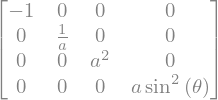

In [4]:
# The Metric Tensor
metric_tensor

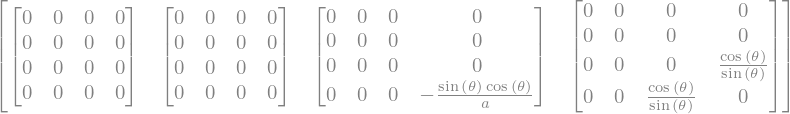

In [5]:
# Christoffel Symbols
christoffel_symbol

In [6]:
# Non-zero Components of the Christoffel Symbols
for i, j, k in product(range(ndim), repeat = 3):
    if christoffel_symbol[i, j, k] != 0:
        display(Latex('$\\Gamma^{{{0}}}{{}}_{{{1} {2}}} = {3}$'.format(latex(coord_sys[i]), latex(coord_sys[j]), latex(coord_sys[k]), latex(christoffel_symbol[i,j,k]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

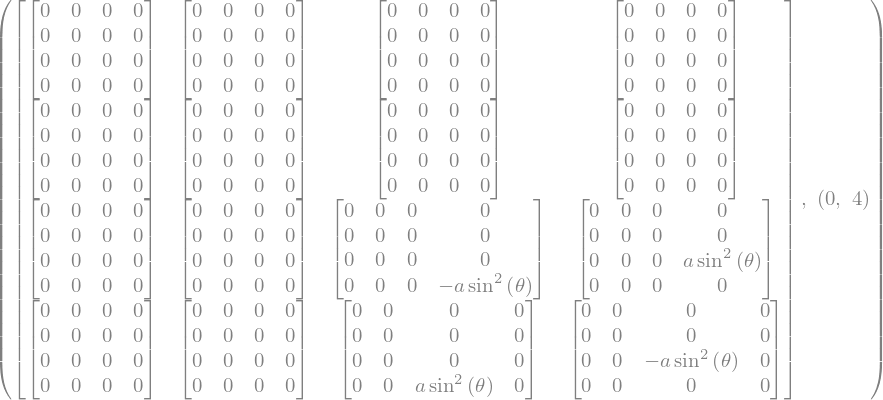

In [7]:
# Riemann Curvature Tensor with given rank
riemann_tensor

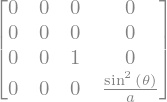

In [8]:
# Ricci Curvature Tensor with rank (0, 4)
ricci_tensor

In [9]:
# Ricci Scalar
ricci_scalar

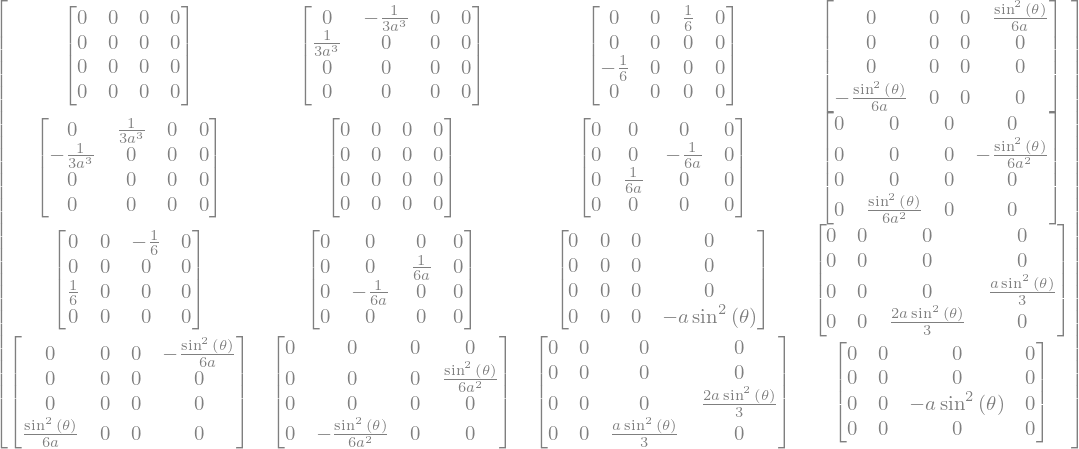

In [10]:
# Weyl Tensor
weyl_tensor

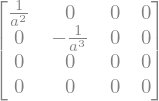

In [11]:
# Einstein Tensor
einstein_tensor

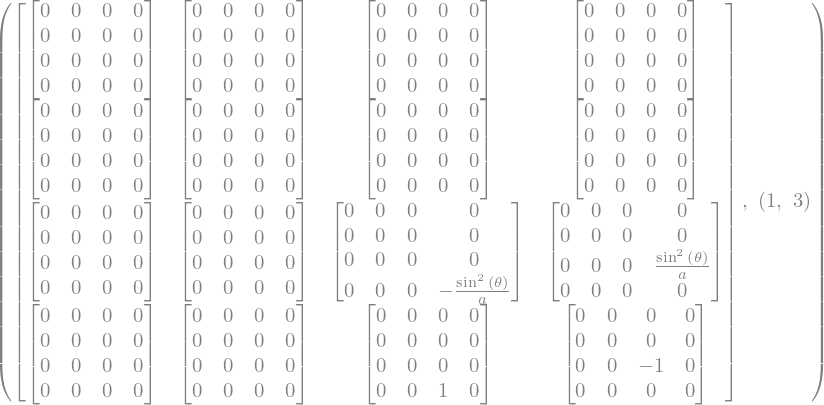

In [12]:
# Riemann Curvature Tensor with rank (1, 3)
riemann_tensorv2